In [1]:
import PIL
import gc
import torch
import torchvision
import os

import numpy as np
import matplotlib.pyplot as plt  
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import Subset
from IPython.core.display import display, HTML
from numpy.random import RandomState
from wide_resnet import WideResNet
from auto_augment import AutoAugment, Cutout
from efficientnet_pytorch import EfficientNet
from cifar_loader import SmallSampleController


# display(HTML("<style>.container { width:40% !important; }</style>"))


In [2]:

def getAcc(preds,targets):
    return np.sum([1 if preds[i] == targets[i] else 0 for i in range(len(preds))])/len(preds)

def train(model, device, train_loader, optimizer, epoch, display=True):
    """
    Summary: Implements the training procedure for a given model
    == params ==
    model: the model to test
    device: cuda or cpu 
    optimizer: the optimizer for our training
    train_loader: dataloader for our train data
    display: output flag
    == output ==
    the mean train loss, the train accuracy
    """
    
    lossTracker = []
    
    targets=[]
    preds=[]
    
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        lossTracker.append(loss.detach())
        with torch.no_grad():
            pred = torch.argmax(output,1).cpu().numpy()
            preds.extend(pred)
            targets.extend(target.cpu().numpy())
        
    lossTracker = [x.item() for x in lossTracker]
    meanLoss = np.mean(lossTracker)
    accuracy = getAcc(preds,targets)
    if display:
        print('Train Epoch: {} [acc: {:.0f}%]\tLoss: {:.6f}'.format(
          epoch, 100. * accuracy, meanLoss))
        
    return accuracy, meanLoss



def test(model, device, test_loader,verbose=True):
    """
    Summary: Implements the testing procedure for a given model
    == params ==
    model: the model to test
    device: cuda or cpu 
    test_loader: dataloader for our test data
    verbose: output flag
    == output ==
    the mean test loss, the test accuracy
    """
    
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            

    meanLoss = test_loss / len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    if verbose: print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        mean_test_loss, correct, len(test_loader.dataset),
        accuracy))
        
    return accuracy, meanLoss


def checkTest(model,device,valSets,valTracker,latexTracker,epoch,
              model_name,optim_name,lr,totalTestSamples,seed,verbose=True):
    """
    Summary: checks the test accuracy, prints, and saves statistics
    """
    tempAcc = []
    tempLoss = []
    for val_loader in valSets:
        acc,loss = test(model, device, val_loader,verbose = False)
        tempAcc.append(acc)
        tempLoss.append(loss)
        
    meanAcc = np.mean(tempAcc)
    stdAcc = np.std(tempAcc)
    
    meanLoss = np.mean(tempLoss)
    if verbose:
        print('[Trained for {} epochs and tested on {} sets of 2000 images]\
        Avg Acc: {:.2f} +- {:.2f} , Avg Loss: {:.2f}'.format(
            epoch,VALIDATION_SET_NUM,meanAcc,stdAcc,meanLoss))
        
        
    tableRow = getLatexRow(architecture=model_name,epoch=epoch,accuracy=meanAcc,optim=optim_name,
                           lr=lr,totalTestSamples=totalTestSamples,dataAug="Nothing",
                           seed=seed,title=False)
    
    latexTracker.append(tableRow)
        
    valTracker["allLoss"].extend(tempLoss)
    valTracker["allAcc"].extend(tempAcc)
    valTracker["meanLoss"].append(meanLoss)
    valTracker["meanAcc"].append(meanAcc)
    valTracker["stdAcc"].append(stdAcc)





In [21]:
def getLatexRow(architecture,epoch,accuracy,optim,lr,
                totalTestSamples,dataAug,seed,title=False):
    """
    Summary: generates one row of latex for a results table
    """
    categories = ["Model","Epoch","Accuracy","Optimizer","lr","Test Sample Num",
                  "data augmentation","seed"]
    row = [str(architecture),str(epoch),str(round(accuracy,3)),str(optim),
           str(lr),str(totalTestSamples),str(dataAug),str(seed)]
    
    if title:
        c = "&".join(categories)
        r = "&".join(row)
        return "{}\\\\\n{}\\\\".format(c,r)
    else:
        r = "&".join(row)
        return "{}\\\\".format(r)
    
    
def plot(xlist,ylist,xlab,ylab,title,color,label,savedir=".",save=False):
    """
    Summary: plots the given list of numbers against its idices and 
    allows for high resolution saving
    """
    fig = plt.figure()
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.plot(xlist,ylist,color=color,marker=".",label=label)
    plt.legend()
    
    if save:
        if not os.path.isdir(savedir):
            os.mkdir(savedir)
        filepath = os.path.join(savedir,"{}".format(title))
        plt.savefig(filepath+".pdf")
        os.system("pdftoppm -png -r 300 {}.pdf {}.png".format(filepath,filepath))
        
    plt.show()
    
    

In [4]:
def getModel(model_name):
    if "wide" in model_name.lower():
        return WideResNet(28, 10, num_classes=10)
    elif "fix" in model_name.lower():
        return EfficientNet.from_pretrained(model_name) # change to not be pretrained
    
    
def getOptimizer128(optimizer_name,parameters):
    if "sgd" in  optimizer_name.lower():
        LR = 0.09
        optim = torch.optim.SGD(parameters, 
                                  lr=LR, momentum=0.9,
                                  weight_decay=0.0005)
        return optim, LR
    elif "adam" in optimizer_name.lower():
        LR = 0.001
        optim = torch.optim.Adam(parameters, 
                              lr=LR, weight_decay=0)
        return optim, LR
        
    

In [5]:
torch.cuda.empty_cache()
gc.collect()

OPTIM = "Adam"
MODEL = "WideResNet28"
EPOCH_NUM = 1000
TRAIN_SAMPLE_NUM = 100
VAL_SAMPLE_NUM = 2000
BATCH_SIZE = 32
VALIDATION_SET_NUM = 5
AUGMENT = True
VAL_DISPLAY_DIVISOR = 4
CIFAR_TRAIN = False

#cifar-10:
#mean = (0.4914, 0.4822, 0.4465)
#std = (0.247, 0.243, 0.261)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
if AUGMENT:
    dataAugmentation = [ 
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        AutoAugment(),
        Cutout()
    ]
    augment = "Crop,Flip,AutoAugment,Cutout"
else: 
    dataAugmentation = []
    augment = "Nothing"



transform_train = transforms.Compose(dataAugmentation + [transforms.ToTensor(), normalize]) 
transform_val = transforms.Compose([transforms.ToTensor(), normalize]) #careful to keep this one same

cifar_train = datasets.CIFAR10(root='.',train=CIFAR_TRAIN, transform=transform_train, download=True)
cifar_val = datasets.CIFAR10(root='.',train=CIFAR_TRAIN, transform=transform_val, download=True)

ss = SmallSampleController(numClasses=10,trainSampleNum=TRAIN_SAMPLE_NUM, # abstract the data-loading procedure
                           valSampleNum=VAL_SAMPLE_NUM, batchSize=BATCH_SIZE, 
                           multiplier=VALIDATION_SET_NUM, trainDataset=cifar_train, 
                           valDataset=cifar_val)
    
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_data, valSets, seed = ss.generateNewSet(device,valMultiplier = VALIDATION_SET_NUM) #Sample from datasets


model = getModel(MODEL).cuda()
optimizer,LR = getOptimizer128(OPTIM,model.parameters())

print(' => Total trainable parameters: %.2fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))        

trainTracker = {"meanLoss":[],"accuracy":[]}
valTracker = {"allLoss":[],"allAcc":[],"meanLoss":[],"meanAcc":[],"stdAcc":[]}
latexTracker = []

print("Begin Train for {} epochs".format(EPOCH_NUM))
for epoch in range(EPOCH_NUM):
    acc, loss = train(model, device, train_data[0], optimizer, epoch+1, display=True)
    trainTracker["meanLoss"].append(loss)
    trainTracker["accuracy"].append(acc)
    
    if (epoch+1) % VAL_DISPLAY_DIVISOR == 0:
        checkTest(model,device,valSets,valTracker,latexTracker,epoch+1,
              model_name=MODEL,optim_name=OPTIM,lr=LR,totalTestSamples=VAL_SAMPLE_NUM*VALIDATION_SET_NUM,
                  seed=seed,verbose=True)
        
          
        
        

Files already downloaded and verified
Files already downloaded and verified
Generated new permutation of the CIFAR train dataset with                 seed:1619889457, train sample num: 100, test sample num: 2000
 => Total trainable parameters: 36.48M
Begin Train for 1000 epochs
Train Epoch: 1 [acc: 1%]	Loss: 2.731586
Train Epoch: 2 [acc: 10%]	Loss: 2.432822
Train Epoch: 3 [acc: 12%]	Loss: 2.260090
Train Epoch: 4 [acc: 10%]	Loss: 2.155126


/home/benjamin/venv/torch11/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


[Trained for 4 epochs and tested on 5 sets of 2000 images]        Avg Acc: 9.95 +- 0.04 , Avg Loss: 24.40
Train Epoch: 5 [acc: 10%]	Loss: 2.106628
Train Epoch: 6 [acc: 10%]	Loss: 2.104845
Train Epoch: 7 [acc: 10%]	Loss: 2.128814
Train Epoch: 8 [acc: 10%]	Loss: 2.094437
[Trained for 8 epochs and tested on 5 sets of 2000 images]        Avg Acc: 11.69 +- 0.24 , Avg Loss: 4.04
Train Epoch: 9 [acc: 10%]	Loss: 2.015676
Train Epoch: 10 [acc: 10%]	Loss: 2.087361
Train Epoch: 11 [acc: 11%]	Loss: 2.002164
Train Epoch: 12 [acc: 11%]	Loss: 1.909845
[Trained for 12 epochs and tested on 5 sets of 2000 images]        Avg Acc: 16.23 +- 0.58 , Avg Loss: 2.37
Train Epoch: 13 [acc: 13%]	Loss: 2.007977
Train Epoch: 14 [acc: 12%]	Loss: 1.916538
Train Epoch: 15 [acc: 11%]	Loss: 2.068859
Train Epoch: 16 [acc: 13%]	Loss: 1.981110
[Trained for 16 epochs and tested on 5 sets of 2000 images]        Avg Acc: 13.70 +- 0.41 , Avg Loss: 3.41
Train Epoch: 17 [acc: 12%]	Loss: 1.966721
Train Epoch: 18 [acc: 13%]	Loss: 

Train Epoch: 124 [acc: 20%]	Loss: 1.776857
[Trained for 124 epochs and tested on 5 sets of 2000 images]        Avg Acc: 13.03 +- 0.20 , Avg Loss: 4.71
Train Epoch: 125 [acc: 21%]	Loss: 1.654673
Train Epoch: 126 [acc: 17%]	Loss: 1.986269
Train Epoch: 127 [acc: 13%]	Loss: 2.012119
Train Epoch: 128 [acc: 16%]	Loss: 1.999122
[Trained for 128 epochs and tested on 5 sets of 2000 images]        Avg Acc: 8.72 +- 0.22 , Avg Loss: 3.42
Train Epoch: 129 [acc: 10%]	Loss: 1.917542
Train Epoch: 130 [acc: 17%]	Loss: 1.939324
Train Epoch: 131 [acc: 11%]	Loss: 2.102762
Train Epoch: 132 [acc: 13%]	Loss: 1.917789
[Trained for 132 epochs and tested on 5 sets of 2000 images]        Avg Acc: 10.04 +- 0.04 , Avg Loss: 2.55
Train Epoch: 133 [acc: 10%]	Loss: 1.891023
Train Epoch: 134 [acc: 10%]	Loss: 2.051720
Train Epoch: 135 [acc: 13%]	Loss: 1.862946
Train Epoch: 136 [acc: 9%]	Loss: 1.884960
[Trained for 136 epochs and tested on 5 sets of 2000 images]        Avg Acc: 11.04 +- 0.24 , Avg Loss: 2.32
Train Epoch

Train Epoch: 241 [acc: 31%]	Loss: 1.442767
Train Epoch: 242 [acc: 33%]	Loss: 1.517899
Train Epoch: 243 [acc: 30%]	Loss: 1.404303
Train Epoch: 244 [acc: 26%]	Loss: 1.509937
[Trained for 244 epochs and tested on 5 sets of 2000 images]        Avg Acc: 17.21 +- 0.73 , Avg Loss: 2.43
Train Epoch: 245 [acc: 36%]	Loss: 1.398581
Train Epoch: 246 [acc: 42%]	Loss: 1.361265
Train Epoch: 247 [acc: 33%]	Loss: 1.547589
Train Epoch: 248 [acc: 31%]	Loss: 1.461367
[Trained for 248 epochs and tested on 5 sets of 2000 images]        Avg Acc: 20.90 +- 0.51 , Avg Loss: 2.37
Train Epoch: 249 [acc: 40%]	Loss: 1.384716
Train Epoch: 250 [acc: 36%]	Loss: 1.562313
Train Epoch: 251 [acc: 34%]	Loss: 1.441078
Train Epoch: 252 [acc: 28%]	Loss: 1.506612
[Trained for 252 epochs and tested on 5 sets of 2000 images]        Avg Acc: 20.12 +- 0.44 , Avg Loss: 2.32
Train Epoch: 253 [acc: 30%]	Loss: 1.480113
Train Epoch: 254 [acc: 36%]	Loss: 1.515078
Train Epoch: 255 [acc: 30%]	Loss: 1.787926
Train Epoch: 256 [acc: 27%]	Los

Train Epoch: 359 [acc: 43%]	Loss: 1.311984
Train Epoch: 360 [acc: 61%]	Loss: 0.977501
[Trained for 360 epochs and tested on 5 sets of 2000 images]        Avg Acc: 23.32 +- 0.33 , Avg Loss: 2.48
Train Epoch: 361 [acc: 44%]	Loss: 1.239274
Train Epoch: 362 [acc: 52%]	Loss: 1.153167
Train Epoch: 363 [acc: 54%]	Loss: 1.036115
Train Epoch: 364 [acc: 50%]	Loss: 1.096679
[Trained for 364 epochs and tested on 5 sets of 2000 images]        Avg Acc: 22.58 +- 0.77 , Avg Loss: 2.82
Train Epoch: 365 [acc: 47%]	Loss: 1.237108
Train Epoch: 366 [acc: 57%]	Loss: 1.129177
Train Epoch: 367 [acc: 40%]	Loss: 1.304571
Train Epoch: 368 [acc: 65%]	Loss: 0.935094
[Trained for 368 epochs and tested on 5 sets of 2000 images]        Avg Acc: 20.33 +- 0.80 , Avg Loss: 3.44
Train Epoch: 369 [acc: 66%]	Loss: 0.938708
Train Epoch: 370 [acc: 57%]	Loss: 1.280975
Train Epoch: 371 [acc: 52%]	Loss: 1.105023
Train Epoch: 372 [acc: 59%]	Loss: 1.035472
[Trained for 372 epochs and tested on 5 sets of 2000 images]        Avg Ac

[Trained for 476 epochs and tested on 5 sets of 2000 images]        Avg Acc: 17.99 +- 0.74 , Avg Loss: 3.43
Train Epoch: 477 [acc: 82%]	Loss: 0.417747
Train Epoch: 478 [acc: 81%]	Loss: 0.468997
Train Epoch: 479 [acc: 73%]	Loss: 0.640481
Train Epoch: 480 [acc: 79%]	Loss: 0.468166
[Trained for 480 epochs and tested on 5 sets of 2000 images]        Avg Acc: 21.39 +- 1.03 , Avg Loss: 3.10
Train Epoch: 481 [acc: 73%]	Loss: 0.552105
Train Epoch: 482 [acc: 72%]	Loss: 0.591558
Train Epoch: 483 [acc: 86%]	Loss: 0.517486
Train Epoch: 484 [acc: 77%]	Loss: 0.617561
[Trained for 484 epochs and tested on 5 sets of 2000 images]        Avg Acc: 20.13 +- 0.59 , Avg Loss: 2.91
Train Epoch: 485 [acc: 67%]	Loss: 0.737320
Train Epoch: 486 [acc: 82%]	Loss: 0.473458
Train Epoch: 487 [acc: 55%]	Loss: 1.307010
Train Epoch: 488 [acc: 80%]	Loss: 0.525660
[Trained for 488 epochs and tested on 5 sets of 2000 images]        Avg Acc: 20.13 +- 0.56 , Avg Loss: 3.42
Train Epoch: 489 [acc: 81%]	Loss: 0.558312
Train Epo

Train Epoch: 593 [acc: 89%]	Loss: 0.380454
Train Epoch: 594 [acc: 85%]	Loss: 0.348671
Train Epoch: 595 [acc: 92%]	Loss: 0.286905
Train Epoch: 596 [acc: 78%]	Loss: 0.528912
[Trained for 596 epochs and tested on 5 sets of 2000 images]        Avg Acc: 18.38 +- 0.66 , Avg Loss: 3.62
Train Epoch: 597 [acc: 83%]	Loss: 0.397928
Train Epoch: 598 [acc: 88%]	Loss: 0.358190
Train Epoch: 599 [acc: 87%]	Loss: 0.354856
Train Epoch: 600 [acc: 84%]	Loss: 0.420857
[Trained for 600 epochs and tested on 5 sets of 2000 images]        Avg Acc: 19.22 +- 1.08 , Avg Loss: 3.53
Train Epoch: 601 [acc: 85%]	Loss: 0.347952
Train Epoch: 602 [acc: 93%]	Loss: 0.223608
Train Epoch: 603 [acc: 88%]	Loss: 0.287404
Train Epoch: 604 [acc: 90%]	Loss: 0.300114
[Trained for 604 epochs and tested on 5 sets of 2000 images]        Avg Acc: 20.12 +- 0.42 , Avg Loss: 3.57
Train Epoch: 605 [acc: 84%]	Loss: 0.407379
Train Epoch: 606 [acc: 86%]	Loss: 0.330715
Train Epoch: 607 [acc: 90%]	Loss: 0.269491
Train Epoch: 608 [acc: 86%]	Los

Train Epoch: 711 [acc: 90%]	Loss: 0.310872
Train Epoch: 712 [acc: 91%]	Loss: 0.222076
[Trained for 712 epochs and tested on 5 sets of 2000 images]        Avg Acc: 21.97 +- 1.06 , Avg Loss: 3.74
Train Epoch: 713 [acc: 91%]	Loss: 0.258532
Train Epoch: 714 [acc: 91%]	Loss: 0.217396
Train Epoch: 715 [acc: 89%]	Loss: 0.334328
Train Epoch: 716 [acc: 89%]	Loss: 0.232658
[Trained for 716 epochs and tested on 5 sets of 2000 images]        Avg Acc: 14.01 +- 0.46 , Avg Loss: 4.20
Train Epoch: 717 [acc: 89%]	Loss: 0.321811
Train Epoch: 718 [acc: 88%]	Loss: 0.281733
Train Epoch: 719 [acc: 88%]	Loss: 0.238208
Train Epoch: 720 [acc: 89%]	Loss: 0.292582
[Trained for 720 epochs and tested on 5 sets of 2000 images]        Avg Acc: 14.02 +- 1.02 , Avg Loss: 4.38
Train Epoch: 721 [acc: 89%]	Loss: 0.239519
Train Epoch: 722 [acc: 88%]	Loss: 0.350681
Train Epoch: 723 [acc: 87%]	Loss: 0.328797
Train Epoch: 724 [acc: 91%]	Loss: 0.258881
[Trained for 724 epochs and tested on 5 sets of 2000 images]        Avg Ac

[Trained for 828 epochs and tested on 5 sets of 2000 images]        Avg Acc: 17.83 +- 0.87 , Avg Loss: 4.38
Train Epoch: 829 [acc: 95%]	Loss: 0.260953
Train Epoch: 830 [acc: 86%]	Loss: 0.394689
Train Epoch: 831 [acc: 92%]	Loss: 0.292975
Train Epoch: 832 [acc: 89%]	Loss: 0.338456
[Trained for 832 epochs and tested on 5 sets of 2000 images]        Avg Acc: 19.52 +- 1.44 , Avg Loss: 3.73
Train Epoch: 833 [acc: 88%]	Loss: 0.222158
Train Epoch: 834 [acc: 94%]	Loss: 0.184312
Train Epoch: 835 [acc: 95%]	Loss: 0.169117
Train Epoch: 836 [acc: 94%]	Loss: 0.139465
[Trained for 836 epochs and tested on 5 sets of 2000 images]        Avg Acc: 18.34 +- 0.51 , Avg Loss: 3.93
Train Epoch: 837 [acc: 93%]	Loss: 0.151024
Train Epoch: 838 [acc: 94%]	Loss: 0.174703
Train Epoch: 839 [acc: 85%]	Loss: 0.464209
Train Epoch: 840 [acc: 95%]	Loss: 0.169526
[Trained for 840 epochs and tested on 5 sets of 2000 images]        Avg Acc: 18.25 +- 0.58 , Avg Loss: 4.33
Train Epoch: 841 [acc: 89%]	Loss: 0.233412
Train Epo

Train Epoch: 945 [acc: 94%]	Loss: 0.159165
Train Epoch: 946 [acc: 96%]	Loss: 0.107098
Train Epoch: 947 [acc: 92%]	Loss: 0.108549
Train Epoch: 948 [acc: 94%]	Loss: 0.210433
[Trained for 948 epochs and tested on 5 sets of 2000 images]        Avg Acc: 16.60 +- 0.43 , Avg Loss: 4.22
Train Epoch: 949 [acc: 72%]	Loss: 0.648863
Train Epoch: 950 [acc: 95%]	Loss: 0.200507
Train Epoch: 951 [acc: 93%]	Loss: 0.165726
Train Epoch: 952 [acc: 83%]	Loss: 0.364673
[Trained for 952 epochs and tested on 5 sets of 2000 images]        Avg Acc: 20.05 +- 1.17 , Avg Loss: 4.13
Train Epoch: 953 [acc: 95%]	Loss: 0.142330
Train Epoch: 954 [acc: 87%]	Loss: 0.305853
Train Epoch: 955 [acc: 86%]	Loss: 0.287800
Train Epoch: 956 [acc: 97%]	Loss: 0.107354
[Trained for 956 epochs and tested on 5 sets of 2000 images]        Avg Acc: 16.39 +- 0.60 , Avg Loss: 4.41
Train Epoch: 957 [acc: 92%]	Loss: 0.178923
Train Epoch: 958 [acc: 94%]	Loss: 0.224344
Train Epoch: 959 [acc: 93%]	Loss: 0.199447
Train Epoch: 960 [acc: 97%]	Los

In [15]:
dirname = latexTracker[-1][:-2] 

def writeTex(latexTracker,dirname):
    if not os.path.isdir(dirname):
        os.mkdir(dirname)
        
    f= open(os.path.join(dirname,"latexTable.txt"),"w")
    for x in latexTracker:
        f.write(x)
    f.close()

writeTex(latexTracker,dirname)

for x in latexTracker:
    print(x)

WideResNet28&4&9.949&Adam&0.001&10000&Nothing&1619889457\\
WideResNet28&8&11.687&Adam&0.001&10000&Nothing&1619889457\\
WideResNet28&12&16.233&Adam&0.001&10000&Nothing&1619889457\\
WideResNet28&16&13.704&Adam&0.001&10000&Nothing&1619889457\\
WideResNet28&20&12.311&Adam&0.001&10000&Nothing&1619889457\\
WideResNet28&24&11.665&Adam&0.001&10000&Nothing&1619889457\\
WideResNet28&28&9.292&Adam&0.001&10000&Nothing&1619889457\\
WideResNet28&32&11.979&Adam&0.001&10000&Nothing&1619889457\\
WideResNet28&36&14.082&Adam&0.001&10000&Nothing&1619889457\\
WideResNet28&40&13.427&Adam&0.001&10000&Nothing&1619889457\\
WideResNet28&44&14.193&Adam&0.001&10000&Nothing&1619889457\\
WideResNet28&48&10.047&Adam&0.001&10000&Nothing&1619889457\\
WideResNet28&52&11.764&Adam&0.001&10000&Nothing&1619889457\\
WideResNet28&56&12.539&Adam&0.001&10000&Nothing&1619889457\\
WideResNet28&60&15.926&Adam&0.001&10000&Nothing&1619889457\\
WideResNet28&64&16.748&Adam&0.001&10000&Nothing&1619889457\\
WideResNet28&68&18.884&Adam&

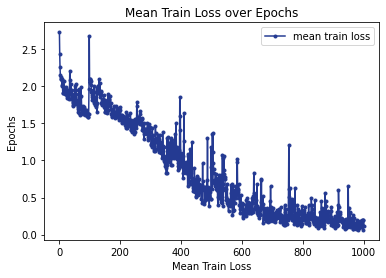

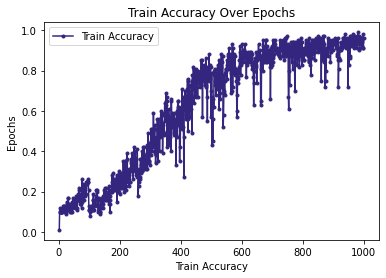

In [22]:

epochList = [x+1 for x in range(len(trainTracker["meanLoss"]))]

plot(xlist=epochList,ylist=trainTracker["meanLoss"],xlab="Mean Train Loss",
    ylab="Epochs",title="Mean Train Loss over Epochs",
    color="#243A92",label="mean train loss",savedir=dirname,save=True)

plot(xlist=epochList,ylist=trainTracker["accuracy"],xlab="Train Accuracy",
    ylab="Epochs",title="Train Accuracy Over Epochs",
    color="#34267E",label="Train Accuracy",savedir=dirname,save=True)

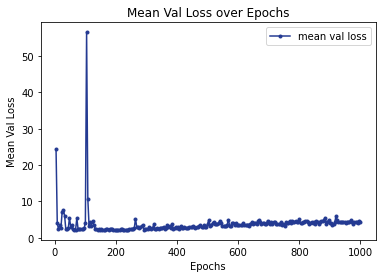

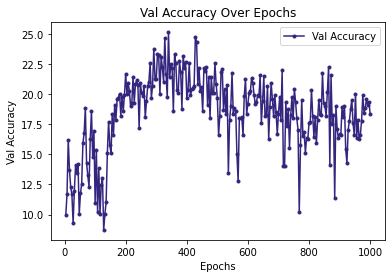

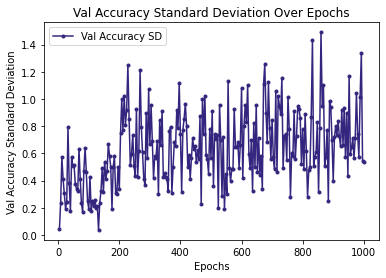

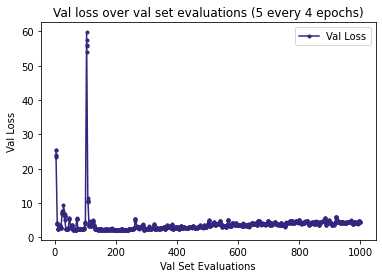

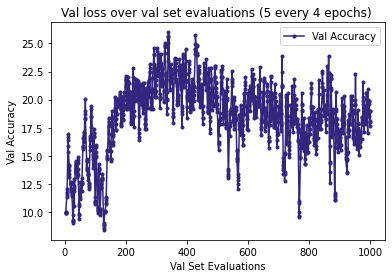

In [23]:

epochList = [VAL_DISPLAY_DIVISOR*(x+1) for x in range(len(valTracker["meanLoss"]))]

plot(xlist=epochList,ylist=valTracker["meanLoss"],xlab="Epochs",
    ylab="Mean Val Loss",title="Mean Val Loss over Epochs",
    color="#243A92",label="mean val loss",savedir=dirname,save=True)

plot(xlist=epochList,ylist=valTracker["meanAcc"],xlab="Epochs",
    ylab="Val Accuracy",title="Val Accuracy Over Epochs",
    color="#34267E",label="Val Accuracy",savedir=dirname,save=True)

plot(xlist=epochList,ylist=valTracker["stdAcc"],xlab="Epochs",
    ylab="Val Accuracy Standard Deviation",title="Val Accuracy Standard Deviation Over Epochs",
    color="#34267E",label="Val Accuracy SD",savedir=dirname,save=True)


valSetEvalCount = VAL_DISPLAY_DIVISOR * EPOCH_NUM * VALIDATION_SET_NUM
epochList = [VAL_DISPLAY_DIVISOR*(x+1) for x in range(len(valTracker["meanLoss"]))\
             for y in range(VALIDATION_SET_NUM)]


plot(xlist=epochList,ylist=valTracker["allLoss"],xlab="Val Set Evaluations",
    ylab="Val Loss",title="Val loss over val set evaluations ({} \
every {} epochs)".format(VALIDATION_SET_NUM,VAL_DISPLAY_DIVISOR),
    color="#34267E",label="Val Loss",savedir=dirname,save=True)

plot(xlist=epochList,ylist=valTracker["allAcc"],xlab="Val Set Evaluations",
    ylab="Val Accuracy",title="Val loss over val set evaluations ({} \
every {} epochs) ".format(VALIDATION_SET_NUM,VAL_DISPLAY_DIVISOR),
    color="#34267E",label="Val Accuracy",savedir=dirname,save=True)